# **Monte Carlo Neuron Simulation**

**Import Statements**

In [1]:
import MCNeuronSim.src.MCNeuronSim.Electrode as MCE
import MCNeuronSim.src.MCNeuronSim.Neuron as MCN
import MCNeuronSim.src.MCNeuronSim.Neuropixel_Shank as MCNS

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('xtick',**{'direction':'in', 'top':True, 'minor.visible':True})
rc('ytick',**{'direction':'in', 'right':True, 'minor.visible':True})

persist_lens = [100,250,500,1000,2000,3000,4000,5000]

#initializing electrode array (I hardcoded the electrode locations because the neuropixel is static)
Electrode_3 = MCE.Electrode(30000, (-8.2,30), "3")
Electrode_4 = MCE.Electrode(30000, (24.6,30), "4")
Electrode_5 = MCE.Electrode(30000, (-24.6,10), "5")
Electrode_6 = MCE.Electrode(30000, (8.2,10), "6")
Electrode_7 = MCE.Electrode(30000, (-8.2,-10), "7")
Electrode_8 = MCE.Electrode(30000, (24.6,-10), "8")
Electrode_9 = MCE.Electrode(30000, (-24.6,-30), "9")
Electrode_10 = MCE.Electrode(30000, (8.2,-30), "10")
Shank = [Electrode_3, Electrode_4, Electrode_5, Electrode_6, Electrode_7, Electrode_8, Electrode_9, Electrode_10]

# Persistence Length Neuron Visualization

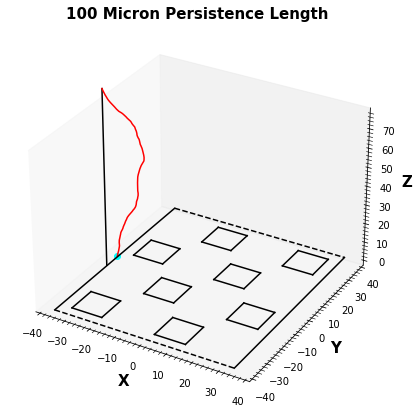

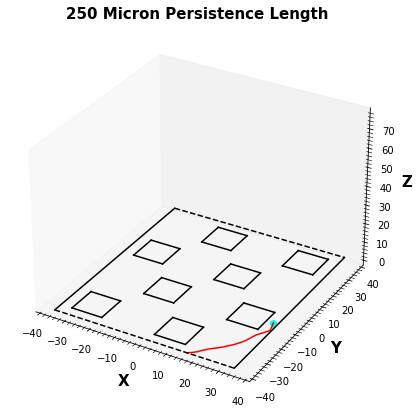

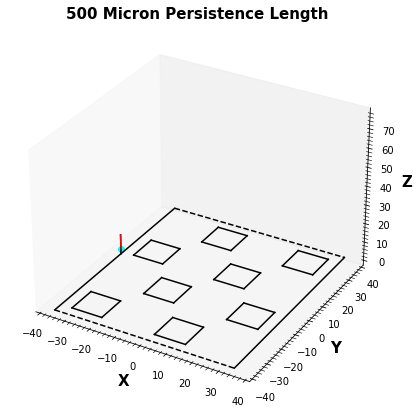

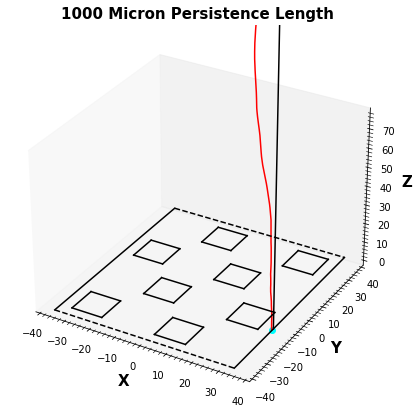

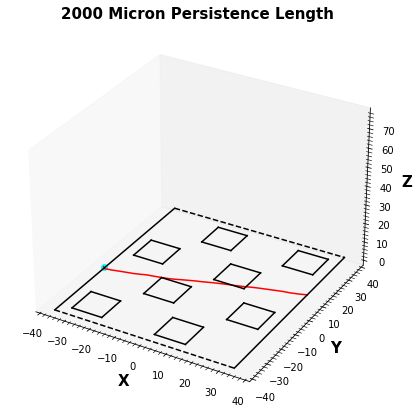

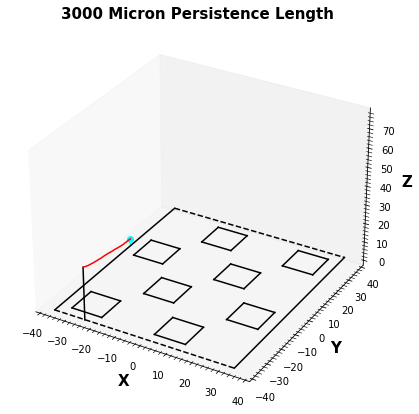

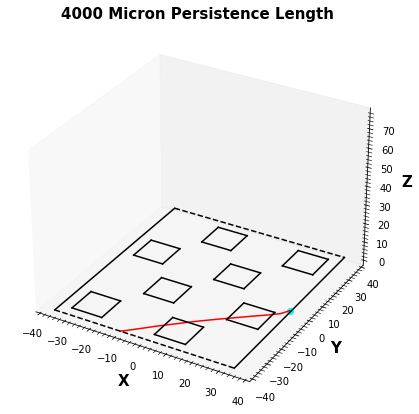

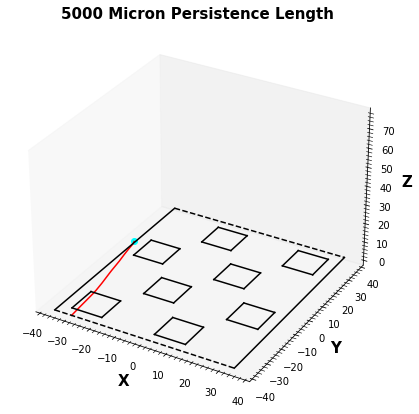

In [2]:
samp_rate = 30000 #[Hz]
bounding  = (-35, 35, -40, 40, 0)


for persist_len in persist_lens:
    x = np.random.choice([-35, 35])
    y = np.random.uniform(-16,16)
    z = np.random.uniform(0,5)
    origin = (x, y, z) #x, y, z [um]
    
    
    N = MCN.Neuron(samp_rate, origin, bounding, persist_len = persist_len)
    ax = N.plot_neuron()
    ax.set_title(str(persist_len) + " Micron Persistence Length", fontsize = 15, fontweight = 'bold')
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)
    ax.set_zlim(-1,79) #these particular bounds chosen so the plot would have equally spaced tick marks
    ax.grid(False)
    
    for electrode in Shank:
        electrode.plot_3D(ax)

# Persistence Length Comparison

In [3]:
MCNeuronSimData = {}
for run in range(1,6):
    print("Starting Run " + str(run))
    fraction = []
    for persist_len in persist_lens:
        neuropixel = MCNS.Neuropixel_Shank(samp_rate = 30000, persist_len = persist_len)
        frac = neuropixel.monte_carlo(10000)
        fraction.append(frac)
        print("Completed Monte Carlo Analysis of Neurons with " + str(persist_len) + " micron persistence length")
    
    MCNeuronSimData[str(run)] = fraction

np.save('MCNeuronSimData.npy', MCNeuronSimData) 

Starting Run 1
Completed Monte Carlo Analysis of Neurons with 100 micron persistence length
Completed Monte Carlo Analysis of Neurons with 250 micron persistence length
Completed Monte Carlo Analysis of Neurons with 500 micron persistence length
Completed Monte Carlo Analysis of Neurons with 1000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 2000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 3000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 4000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 5000 micron persistence length
Starting Run 2
Completed Monte Carlo Analysis of Neurons with 100 micron persistence length
Completed Monte Carlo Analysis of Neurons with 250 micron persistence length
Completed Monte Carlo Analysis of Neurons with 500 micron persistence length
Completed Monte Carlo Analysis of Neurons with 1000 micron persistence length
Completed Monte Carlo Analysis of Neuron

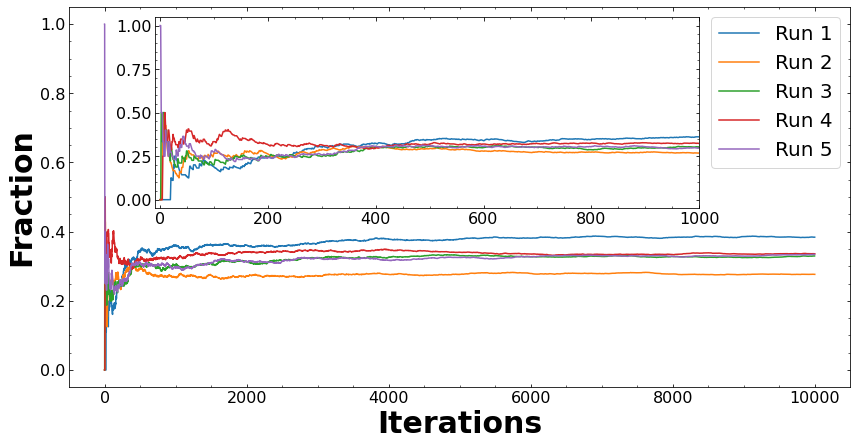

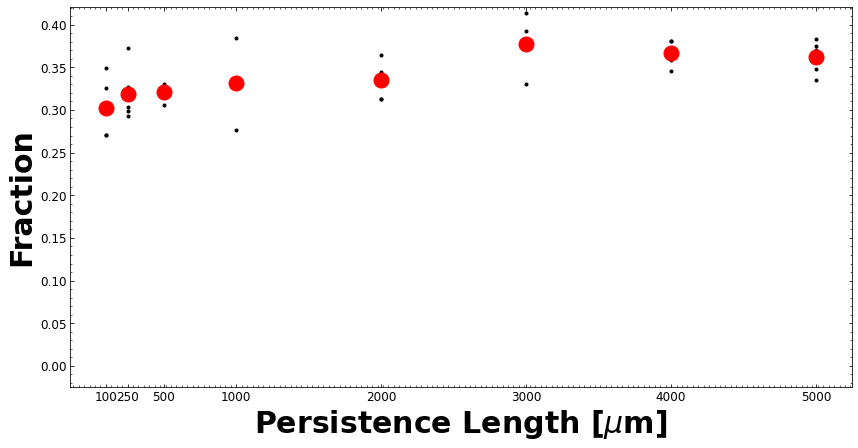

In [4]:
'''
Selected Monte Carlo Full Analysis Display
'''
rc('font',**{'size':16})
# Load data
loaded_data = np.load('MCNeuronSimData.npy',allow_pickle='TRUE').item()
left, bottom, width, height = [0.21, 0.48, 0.54, 0.38]

#Plot Monte Carlo Analysis in full
fig, ax1 = plt.subplots(figsize = (14,7))
ax2 = fig.add_axes([left, bottom, width, height])
ax1.set_ylabel("Fraction", fontweight = "bold", fontsize = 30)
ax1.set_xlabel("Iterations", fontweight = "bold", fontsize = 30)
for run in range(1,6):
    ax1.plot(loaded_data[str(run)][3], label = "Run " + str(run)) #index 3 of each run is neurons with 1000 micron persistence length
    ax2.plot(loaded_data[str(run)][3])
ax1.legend(fontsize = 20)
ax2.set_xlim(-10, 1000)
plt.show()
    
'''
Persistence Length Comparison Plot
'''    
rc('font',**{'size':12})
#Plot Persistence Length Comaprison
plt.figure(figsize = (14,7))
plt.xlabel(r"Persistence Length [$\mu$m]", fontweight = "bold", fontsize = 30)
plt.ylabel("Fraction", fontweight = "bold", fontsize = 30)

#Retrieving data from dictionary vertically to retrieve mean for each persistence length
frac_range = []
means = []
for i in range(len(persist_lens)):
    final_fracs = []
    for run in range(1,6):
        final_frac = loaded_data[str(run)][i][-1]
        final_fracs.append(final_frac)
    frac_range.append(final_fracs)
    means.append(np.mean(final_fracs))
frac_range = np.array(frac_range).T #transpose 2d array to get data horizontally 

#plotting persistence length range
for final_fracs in frac_range:
    plt.plot(persist_lens, final_fracs, linestyle = '', marker = '.', c = 'black')
plt.plot(persist_lens, means, linestyle = '', marker = 'o', c = 'red', markersize = 15)
plt.ylim(bottom = -0.025)
plt.xticks(persist_lens)
plt.show()